In [2]:
########################################################### IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflow
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../src')
from data_preparation import get_birth_data, separate_data

import datetime

########################################################### DATA
data = get_birth_data()

########################################################### for xlabels (xticks)
def get_xticks(data):
    pos = []; labels_m = []

    yr = data.year[data.index[0]]
    labels_y = str(yr)
    last_yr = data.year[data.index[-1]]
    for i in range(last_yr-yr):
        df = data.loc[data.year == yr+i]
        labels_y = labels_y + ', ' + str(yr+i)

    l = data.month[data.index[0]]
    last_l = data.month[data.index[-1]]
    for i in range(last_l-l):
        df = data.loc[data.month == l+i]
        month_number = str(l+i)
        datetime_object = datetime.datetime.strptime(month_number, "%m")
        labels_m.append(datetime_object.strftime("%b"))
        pos.append(df.index[0])
    return pos, labels_m, labels_y

In [3]:
def split_dataframe_by_position(df, splits):
    """
    Takes a dataframe and an integer of the number of splits to create.
    Returns a list of dataframes.
    """
    dataframes = []
    index_to_split = len(df) // splits
    start = 0
    end = index_to_split
    for split in range(splits):
        temporary_df = df.iloc[start:end, :]
        dataframes.append(temporary_df)
        start += index_to_split
        end += index_to_split
    return dataframes

In [4]:
def gp_split_fit_pred(x, y, k, title, x_test, y_test, pos=None, labels=None, yrs=None, trainable=None):

    diagnostics = {
        "Initial likelihood": 0,
        "Obj Likelihood": 0,
        "Avg predictive variance": 0,
        "MSE Train": 0,
        "MSE Test": 0
    }
    
    gp = gpflow.models.GPR(data=(x, y), kernel=k, mean_function=None)

    if trainable:
        try:
            set_trainable(gp.kernel.kernels[0].period, False)
        except: 
            print("No period parameter present")
        set_trainable(gp.likelihood.variance , False)
        print('Initial Model Summary')
        print_summary(gp, fmt="notebook")
        diagnostics["Initial likelihood"] = gp.log_marginal_likelihood().numpy()
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables)
    print('Optimisation Summary')
    print_summary(gp, fmt="notebook")
    diagnostics["Obj Likelihood"] = gp.maximum_log_likelihood_objective().numpy()
    
    mu, var = gp.predict_f(x)
    mu_test, var_test = gp.predict_f(x_test)
    diagnostics["Avg predictive variance"] = np.mean(var)
    diagnostics['MSE Train'] = mean_squared_error(y, mu)
    diagnostics['MSE Test'] = mean_squared_error(y_test, mu_test) 

    plt.figure(figsize=(20,7))
    plt.xticks(pos, labels)
    plt.plot(x, y, '.', label='train data', c='black', markersize=3)
    plt.plot(x_test, y_test, 'x', label='test data', c='red', markersize=5)

    plt.plot(x, mu, '-', label='Train - mean predictive posterior', c='C0', linewidth=3)
    vv = 1.96 * np.sqrt(var) 
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.4, edgecolor='gray', facecolor='C0')

    plt.vlines(x_test[0], colors='grey', linestyles='dashed', ymin=np.min(y), ymax=np.max(y))

    vv = 1.96 * np.sqrt(var_test) 
    plt.plot(x_test, mu_test, '-', label='Test - mean predictive posterior', c='maroon', linewidth=3)
    plt.fill_between(x_test[:,0], (mu_test-vv)[:,0], (mu_test+vv)[:,0], alpha=0.4, edgecolor='gray', facecolor='grey')
    
    plt.title('Sliding window with kernel: ' + title)
    plt.xlabel('Months in ' + yrs)
    plt.ylabel('Normalised number of births')
    
    plt.legend()
    plt.show()
    
    print(pd.DataFrame(diagnostics.items()))
    return opt_logs

--------------------
 SLIDING WINDOW  0
--------------------
Initial Model Summary


2022-06-23 12:20:31.052865: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-23 12:20:31.630313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2022-06-23 12:20:31.802448: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


2022-06-23 12:20:32.246452: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7c374a0


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.288626
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.658715
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.1214e-07
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.39706
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


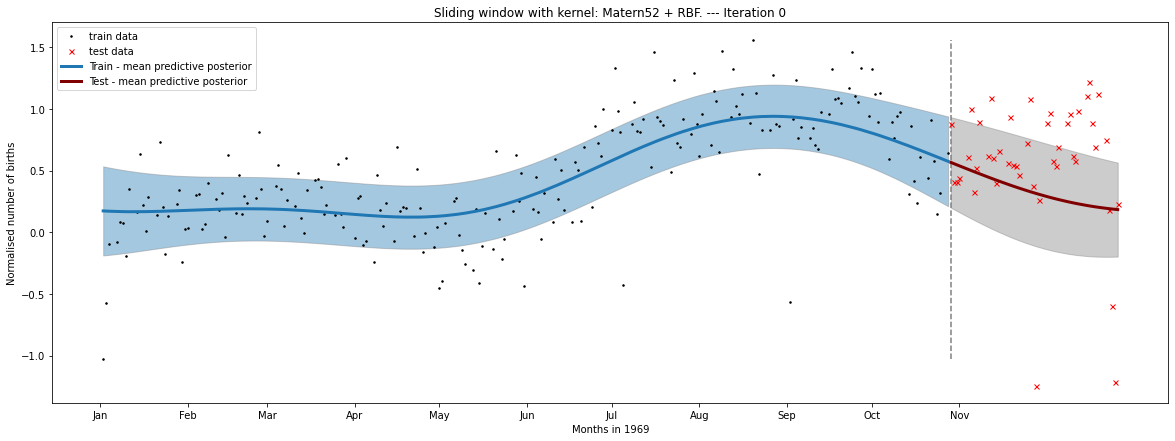

                         0           1
0       Initial likelihood -273.403685
1           Obj Likelihood -214.102324
2  Avg predictive variance    0.019115
3                MSE Train    0.095891
4                 MSE Test    0.313877
--------------------
 SLIDING WINDOW  1
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.332465
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.874192
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.24923e-09
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.27887
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


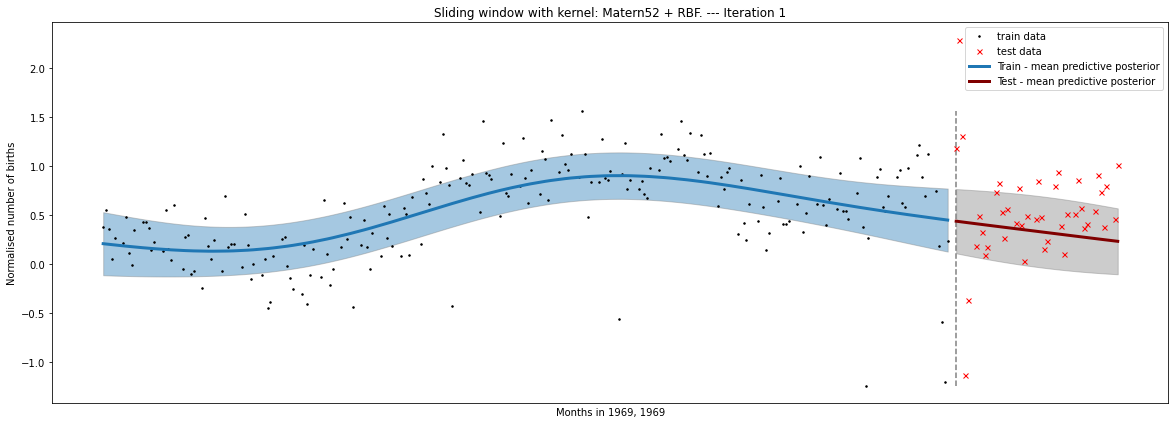

                         0           1
0       Initial likelihood -275.911427
1           Obj Likelihood -218.212579
2  Avg predictive variance    0.016522
3                MSE Train    0.131772
4                 MSE Test    0.286074
--------------------
 SLIDING WINDOW  2
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.326478
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.784891
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,5.21549e-08
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.465847
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


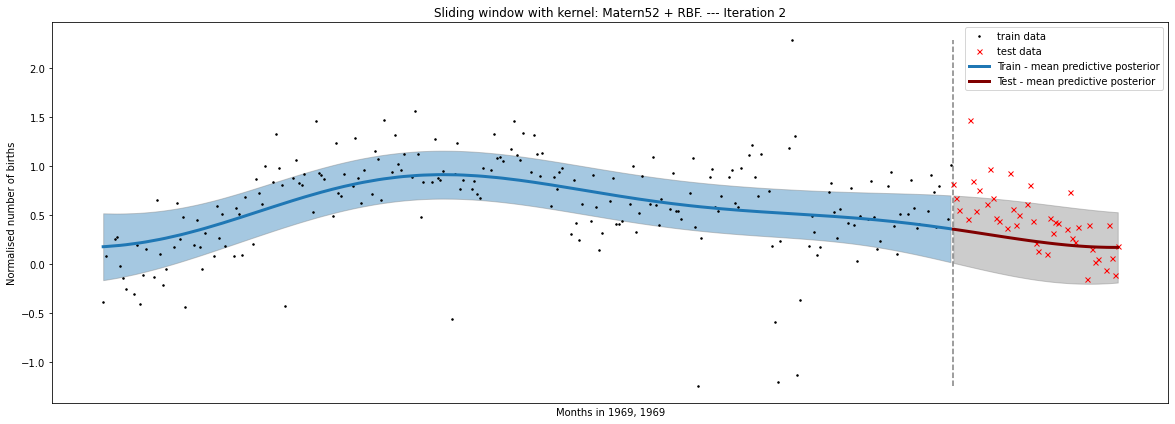

                         0           1
0       Initial likelihood -276.660127
1           Obj Likelihood -221.681434
2  Avg predictive variance    0.017609
3                MSE Train    0.170317
4                 MSE Test    0.116969
--------------------
 SLIDING WINDOW  3
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.448936
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.28566
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,5.24312e-09
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.246805
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


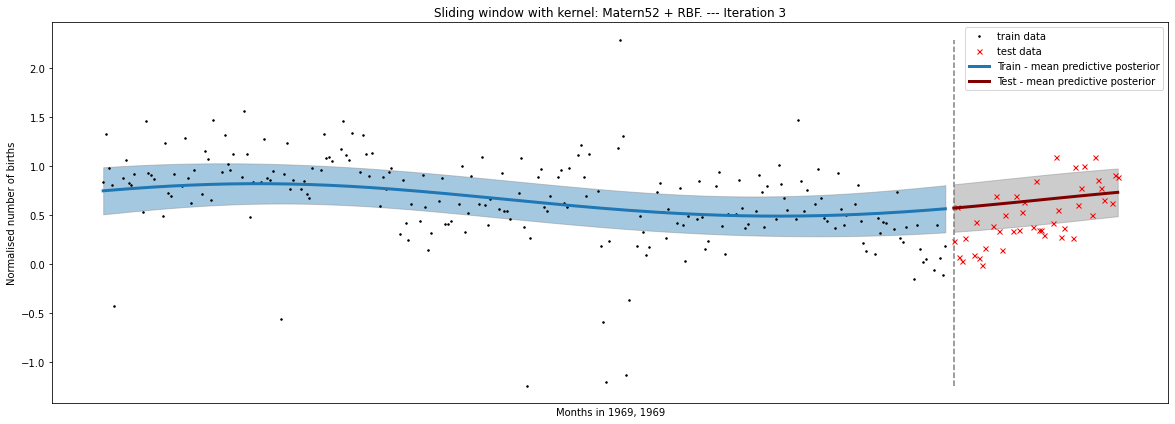

                         0           1
0       Initial likelihood -277.179204
1           Obj Likelihood -220.921055
2  Avg predictive variance    0.011053
3                MSE Train    0.174390
4                 MSE Test    0.093785
--------------------
 SLIDING WINDOW  4
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.345768
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.90201
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,2.36296e-08
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.361934
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


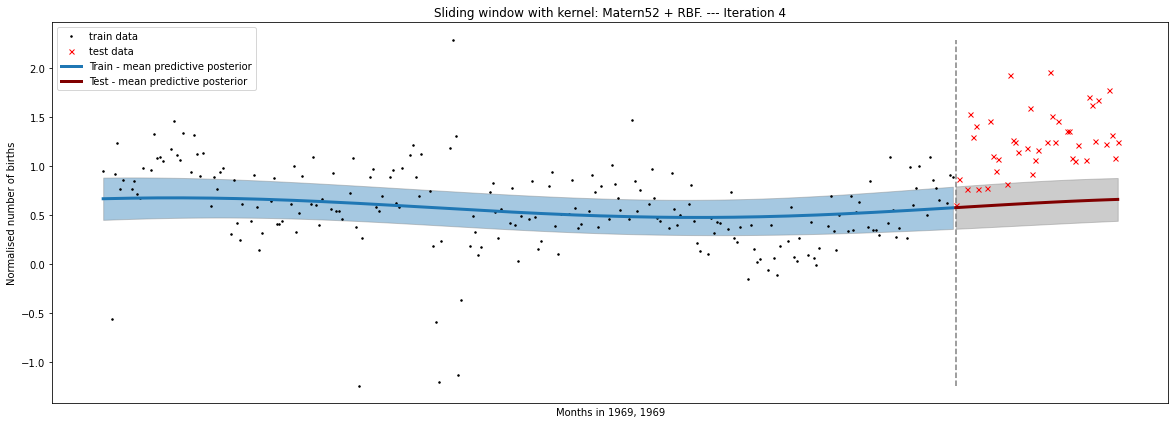

                         0           1
0       Initial likelihood -275.308905
1           Obj Likelihood -218.601137
2  Avg predictive variance    0.009331
3                MSE Train    0.169174
4                 MSE Test    0.483159
--------------------
 SLIDING WINDOW  5
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.526827
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.747891
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.50142e-09
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.323971
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


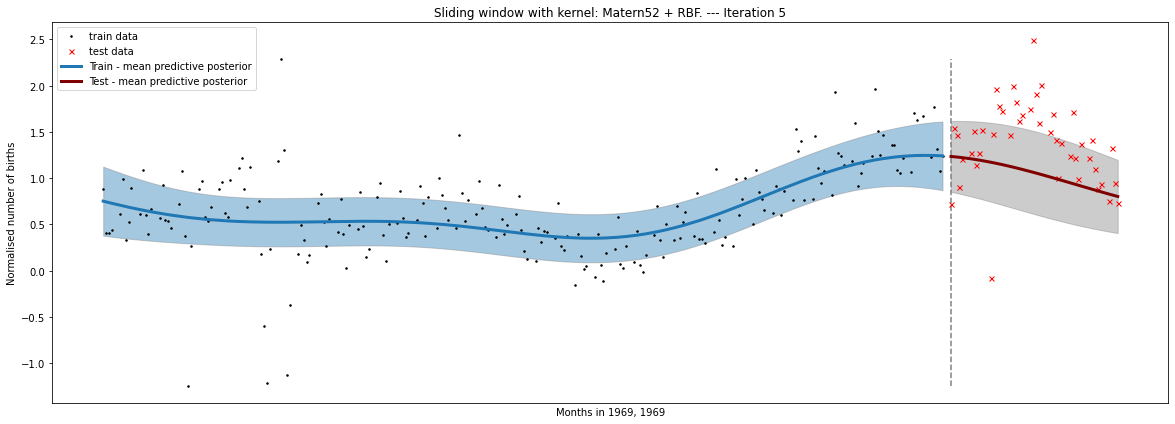

                         0           1
0       Initial likelihood -275.850905
1           Obj Likelihood -220.429700
2  Avg predictive variance    0.019897
3                MSE Train    0.146051
4                 MSE Test    0.295587
--------------------
 SLIDING WINDOW  6
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.785464
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.990563
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.78572e-06
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.573027
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


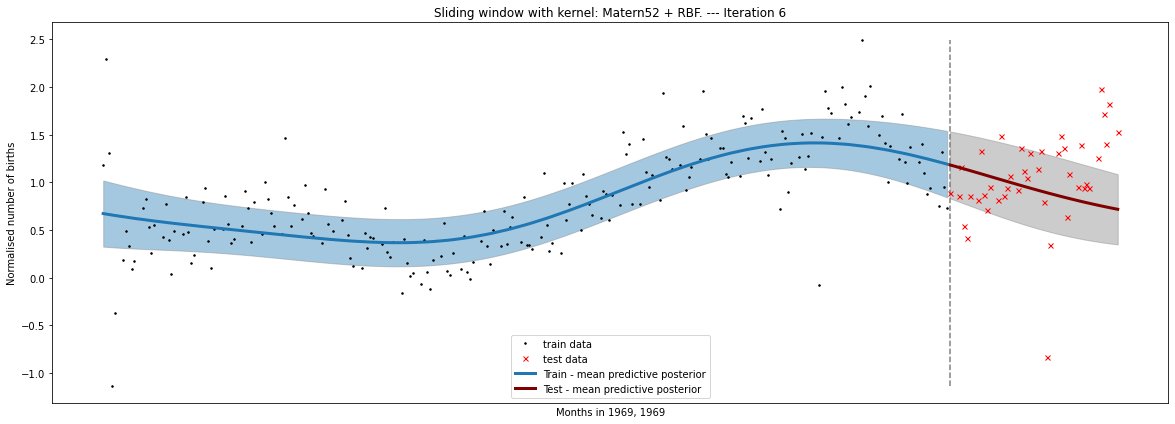

                         0           1
0       Initial likelihood -275.260137
1           Obj Likelihood -218.693759
2  Avg predictive variance    0.018099
3                MSE Train    0.132365
4                 MSE Test    0.285619
--------------------
 SLIDING WINDOW  7
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.822439
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.891679
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,5.51903e-09
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.339485
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


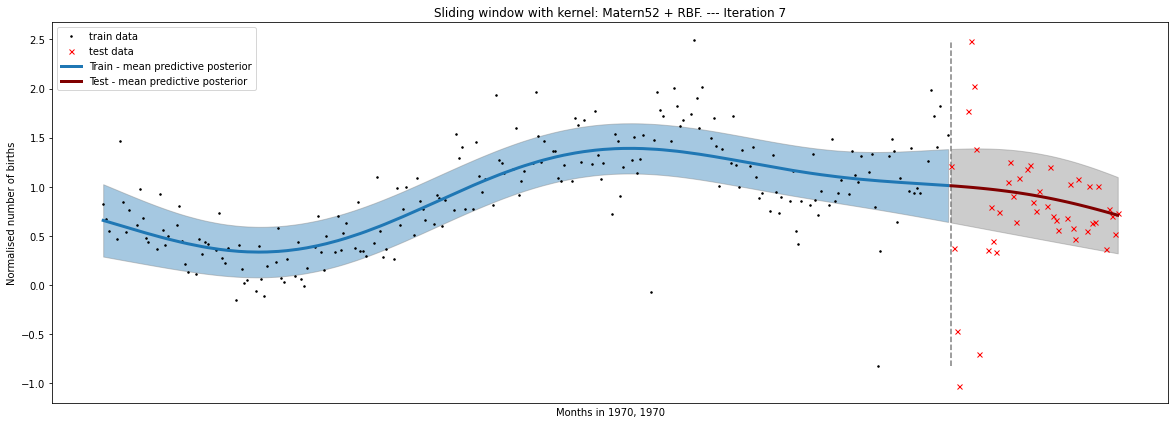

                         0           1
0       Initial likelihood -275.096184
1           Obj Likelihood -218.237332
2  Avg predictive variance    0.019393
3                MSE Train    0.122781
4                 MSE Test    0.368353
--------------------
 SLIDING WINDOW  8
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.809487
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.03309
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,6.15931e-09
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.577301
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


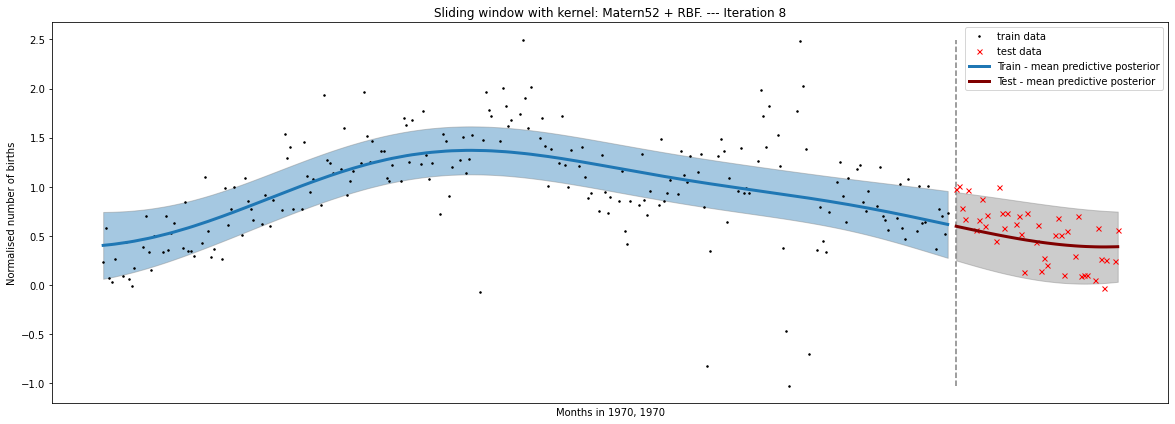

                         0           1
0       Initial likelihood -278.763484
1           Obj Likelihood -225.491279
2  Avg predictive variance    0.017711
3                MSE Train    0.187250
4                 MSE Test    0.059178
--------------------
 SLIDING WINDOW  9
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.923046
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.54806
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.80298e-09
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.57021
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


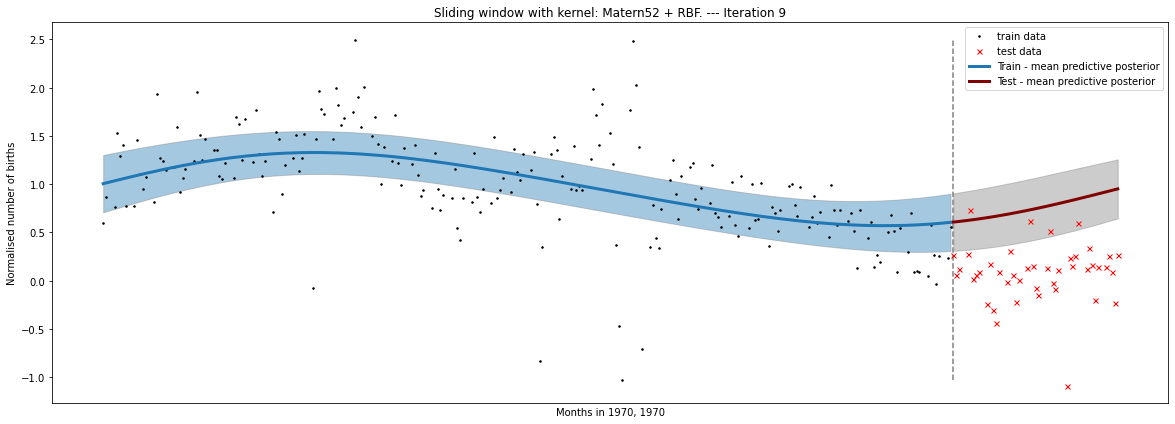

                         0           1
0       Initial likelihood -277.359612
1           Obj Likelihood -224.092715
2  Avg predictive variance    0.014626
3                MSE Train    0.194533
4                 MSE Test    0.556734
--------------------
 SLIDING WINDOW  10
--------------------
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.697985
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.779208
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.49689e-09
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.50376
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


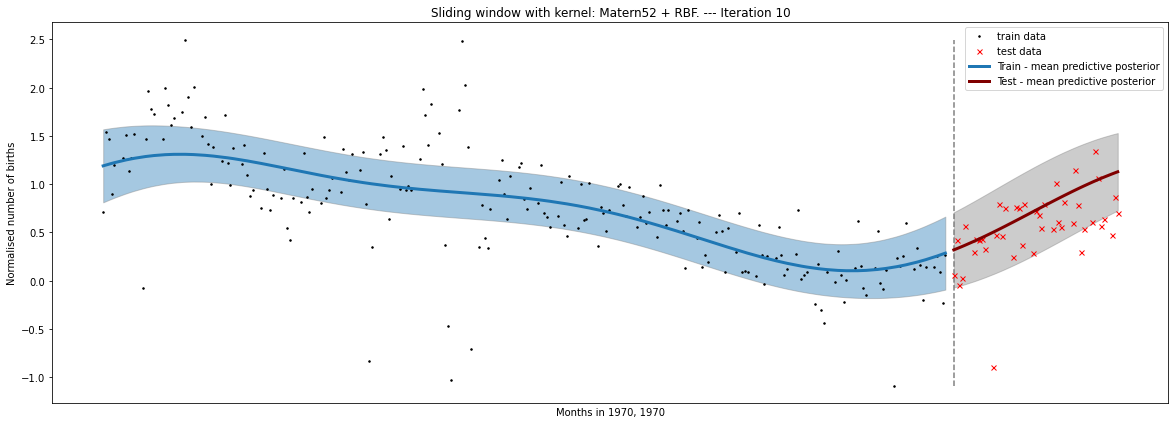

                         0           1
0       Initial likelihood -279.072404
1           Obj Likelihood -226.253280
2  Avg predictive variance    0.020358
3                MSE Train    0.185918
4                 MSE Test    0.125386


In [5]:
splits = 121 # two month split
split_dataframes = split_dataframe_by_position(data, splits)

escape = 1

window_size = 5
for i in range(splits-window_size):
    print('--------------------')
    print(' SLIDING WINDOW ', i)
    print('--------------------')
    df = pd.DataFrame()

    for df_ind in range(window_size):
        if df_ind == 0:
            df = split_dataframes[i]
        else :
            df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

    whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
    pos, labels, yrs = get_xticks(whole_data)
    x_train, y_train = separate_data(df, normalised=True, weekdays=True)
    x_test, y_test = separate_data(split_dataframes[i+window_size], normalised=True, weekdays=True)

    #k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
    k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
    gp_split_fit_pred(x_train, y_train, k, title='Matern52 + RBF. --- Iteration ' + str(i), x_test=x_test, y_test=y_test, pos=pos, labels=labels, yrs=yrs, trainable=True)

    if (i==10) & (escape==1):
        break
    